In [ ]:
# Author: Banafsheh Khazali
# Date: March 01, 2023

# **Semantic Text Similarity on Medical Symptoms** 


In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shoko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

## **Scraping the data**

To scrape the data, We can use Python libraries such as BeautifulSoup and requests. 



In [ ]:
# Define the URL of the symptom checker page
url = 'https://www.mayoclinic.org/symptom-checker/select-symptom/itt-20009075'

# Send a GET request to the URL
session = requests.Session()
response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the section of the page that contains adult symptoms
adult_symptoms_section = soup.find('div', {'class': 'adult'})
# Check that the adult symptoms section was found
if adult_symptoms_section:
    # Find all links within the adult symptoms section
    adult_symptom_links = adult_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    adult_symptom_urls = [link['href'] for link in adult_symptom_links]

    


# Find the section of the page that contains child symptoms
child_symptoms_section = soup.find('div', {'class': 'child'})

# Check that the child symptoms section was found
if child_symptoms_section:
    # Find all links within the child symptoms section
    child_symptom_links = child_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    child_symptom_urls = [link['href'] for link in child_symptom_links]



# Print the URLs for the adult symptoms
full_adult_url = []
for i in adult_symptom_urls:
  full_adult_url.append("https://www.mayoclinic.org/"+i)

print('\nAdult Symptom URLs:', full_adult_url)

# Print the URLs for the child symptoms
full_child_urls = []
for i in child_symptom_urls:
  full_child_urls.append("https://www.mayoclinic.org/"+i)

print('\nChild Symptom URLs:', full_child_urls)



Adult Symptom URLs: ['https://www.mayoclinic.org//symptom-checker/abdominal-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/blood-in-stool-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/chest-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/constipation-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/cough-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/diarrhea-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/difficulty-swallowing-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/dizziness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/eye-discomfort-and-redness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclini

In [ ]:
!mkdir corpus

A subdirectory or file corpus already exists.


In [ ]:
pwd

'D:\\University\\1-Calgary\\NLP\\Assignment\\project'

**extract adult symptoms**

In [ ]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_adult_url):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    adult_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if adult_symptoms_section is not None:
        name = full_adult_url[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"D:/University/1-Calgary/NLP/Assignment/project/corpus/{filename}", 'w') as f:
            f.write(adult_symptoms_section.text)
    else:
        print(f"No 'adult' section found on page {i+1}")

**extract children symptoms**

In [ ]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_child_urls):
#     response = requests.get(url)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.content, 'html.parser')
    child_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if child_symptoms_section is not None:
        name = full_child_urls[i].split('/')[-3].rsplit('-', 1)[0]
        filename = f'{name}.txt'
        with open(f"D:/University/1-Calgary/NLP/Assignment/project/corpus/{filename}", 'w') as f:
            f.write(child_symptoms_section.text)
    else:
        print(f"No 'child' section found on page {i+1}")

## **Preprocessing the data**

To preprocess the data, We may need to clean and tokenize the text, remove stop words, and perform stemming or lemmatization.

In [ ]:
!mkdir pre_corpus

**Preprocess adult/child files**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

# Define the directory where the text files are located
corpus_dir_in = 'D:/University/1-Calgary/NLP/Assignment/project/corpus'
corpus_dir_out = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# Create the output directory if it doesn't exist
if not os.path.exists(corpus_dir_out):
    os.makedirs(corpus_dir_out)


# Loop over the input files
for filename in os.listdir(corpus_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(corpus_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(corpus_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shoko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shoko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shoko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed file: abdominal-pain-in-adults.txt
Processed file: abdominal-pain-in-children.txt
Processed file: blood-in-stool-in-adults.txt
Processed file: chest-pain-in-adults.txt
Processed file: constipation-in-adults.txt
Processed file: constipation-in-children.txt
Processed file: cough-in-adults.txt
Processed file: cough-in-children.txt
Processed file: diarrhea-in-adults.txt
Processed file: diarrhea-in-children.txt
Processed file: difficulty-swallowing-in-adults.txt
Processed file: dizziness-in-adults.txt
Processed file: ear-problems-in-children.txt
Processed file: earache-in-children.txt
Processed file: eye-discomfort-and-redness-in-adults.txt
Processed file: eye-discomfort-and-redness-in-children.txt
Processed file: eye-problems-in-adults.txt
Processed file: eye-problems-in-children.txt
Processed file: fever-in-children.txt
Processed file: foot-pain-or-ankle-pain-in-adults.txt
Processed file: foot-swelling-or-leg-swelling-in-adults.txt
Processed file: headaches-in-adults.txt
Process

## **Calculating the similarity**

Calculate the similarity between the two document-term matrices using a similarity metric such as cosine similarity or Jaccard similarity.

In [ ]:
# Define directory path containing text files
dir_path = 'D:/University/1-Calgary/NLP/Assignment/project/pre_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
corpus = []
for file_name in file_names:
    with open(os.path.join(dir_path, file_name), 'r') as f:
        text = f.read()
        corpus.append(text)

# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[1.         0.83983551 0.8129776  ... 0.75203421 0.70872791 0.66964885]
 [0.83983551 1.         0.79466237 ... 0.75158403 0.73104262 0.7077631 ]
 [0.8129776  0.79466237 1.         ... 0.73824127 0.72051996 0.67798415]
 ...
 [0.75203421 0.75158403 0.73824127 ... 1.         0.73644373 0.69639313]
 [0.70872791 0.73104262 0.72051996 ... 0.73644373 1.         0.92706968]
 [0.66964885 0.7077631  0.67798415 ... 0.69639313 0.92706968 1.        ]]


##  Visualize the similarity results using a heatmap or a dendrogram

The dendrogram shows the hierarchical clustering of the documents based on their similarity.

The heatmap shows the similarity matrix as a color-coded grid, where darker colors indicate higher similarity. 

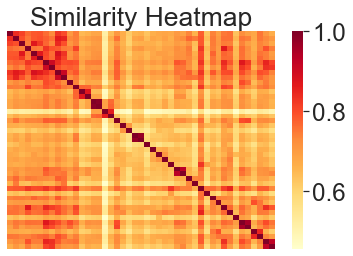

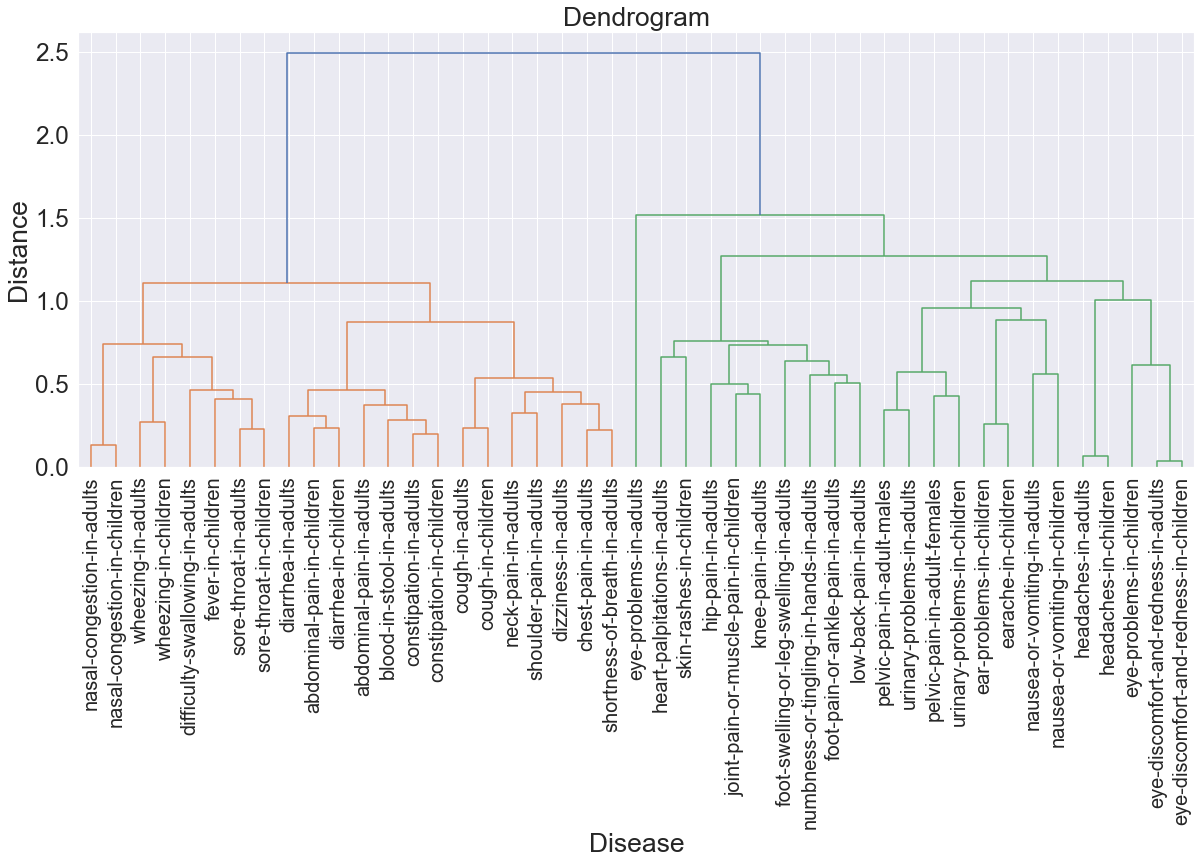

In [ ]:
# Create heatmap
sns.set(font_scale=2.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Similarity Heatmap')
plt.show()


# Create dendrogram
# plt.rcParams.update({'font.size': 100})
plt.figure(figsize=(20, 8))
f_names = [i.split('.')[0] for i in file_names]
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'), labels =f_names )
plt.xticks(fontsize= 20)
plt.title('Dendrogram')
plt.xlabel('Disease')
plt.ylabel('Distance')
plt.show()

## **Find Similar Diseases**

Using clustering algorithms such as K-means clustering or Hierarchical clustering to find similar diseases in the document.

In [ ]:
# Cluster documents using K-means
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# Print the top 5 documents in each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_indices = np.where(km.labels_ == i)[0]
    cluster_similarity_scores = similarity_matrix[cluster_indices][:, cluster_indices]
    cluster_top_indices = np.argsort(-cluster_similarity_scores.sum(axis=1))[:5]
    for j in cluster_top_indices:
        print(f"- Document {cluster_indices[j]}: {os.listdir(dir_path)[cluster_indices[j]]}")

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
- Document 22: headaches-in-children.txt
- Document 21: headaches-in-adults.txt
- Document 17: eye-problems-in-children.txt
- Document 16: eye-problems-in-adults.txt
Cluster 1:
- Document 6: cough-in-adults.txt
- Document 32: neck-pain-in-adults.txt
- Document 39: sore-throat-in-adults.txt
- Document 36: shortness-of-breath-in-adults.txt
- Document 7: cough-in-children.txt
Cluster 2:
- Document 8: diarrhea-in-adults.txt
- Document 9: diarrhea-in-children.txt
- Document 4: constipation-in-adults.txt
- Document 1: abdominal-pain-in-children.txt
- Document 5: constipation-in-children.txt


In [ ]:
# Compute the hierarchical clustering of the similarity matrix
linkage_matrix = linkage(similarity_matrix, method='ward')

# Plot a dendrogram of the hierarchical clustering
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=file_names)
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

TypeError: 'dict' object is not callable

<Figure size 1080x720 with 0 Axes>

In [ ]:
# different similarity method
# ANALYZE THE plots
# measures other than TDIDF
# validation on the results
